# [E-10] 인물사진을 만들어 보자

오늘 만들어볼 목표는 핸드폰 인물사진 모드입니다. 사실 핸드폰 인물 사진 모드를 정확히 따라 하기 위해서 2개의 렌즈가 필요하지만 딥러닝을 적용해서 하나의 렌즈만으로 비슷하게 흉내 내 보겠습니다.

## 00. import

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import warnings
warnings.filterwarnings(action='ignore')

import urllib # 웹에서 데이터를 다운로드할 때 사용
import cv2 # OpenCV 라이브러리로 이미지를 처리하기 위해 필요
from pixellib.semantic import semantic_segmentation # 시맨틱 세그멘테이션을 편하게 사용할 수 있는 라이브러리

## 01. Data

(1440, 1080, 3)


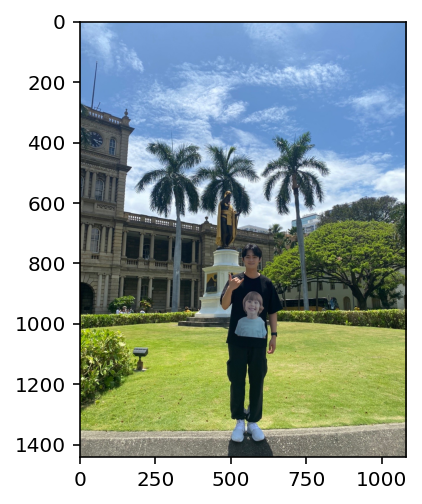

In [2]:
# imp read
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/hawai.jpg'  
img_orig = cv2.imread(img_path) 

# img shape
print(img_orig.shape)

#convert bgr to rgb
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

## 02. Model

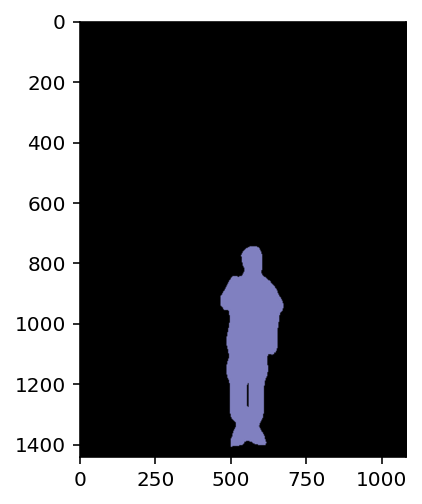

In [3]:
# 저장할 파일 이름을 결정합니다
model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5')

# PixelLib가 제공하는 모델의 url입니다
model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5'

# 다운로드를 시작합니다
urllib.request.urlretrieve(model_url, model_file)

# 모델 생성
model = semantic_segmentation()
model.load_pascalvoc_model(model_file)

# 이미지 입력
segvalues, output = model.segmentAsPascalvoc(img_path)

plt.imshow(output)
plt.show()

In [4]:
# Label_names
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]

# color_map 만들기
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)
for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

# label 이름과 크로마키하는 색깔 출력
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id], colormap[class_id])

background [0 0 0]
person [192 128 128]


# 03. Shallow Focus

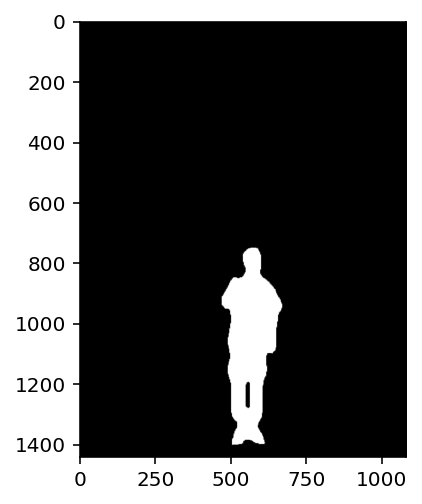

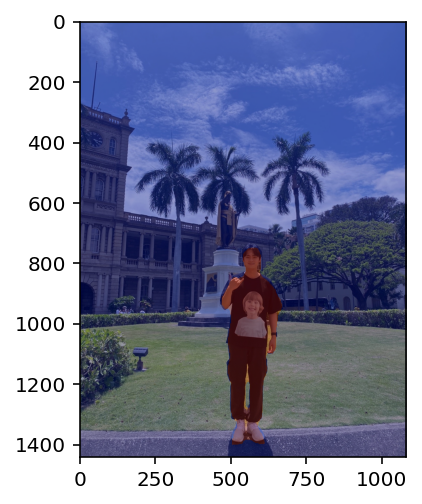

In [5]:
'''
output 이미지가 BGR 순서로 채널 배치가 되어 있다는 점이에요. colormap은 RGB 순서
'''

# 사람 object 구별하는 색깔 (BGR)
seg_color = (128,128,192)

# output의 픽셀 별로 색상이 seg_color와 같다면 1(True), 다르다면 0(False)이 됩니다
seg_map = np.all(output==seg_color, axis=-1)

# 흑백사진으로 바꾸기
plt.imshow(seg_map, cmap='gray')
plt.show()


# 색깔 넣어서 잘 나눠졌나 확인해보기
img_show = img_orig.copy()
# True과 False인 값을 각각 255과 0으로 바꿔줍니다
img_mask = seg_map.astype(np.uint8) * 255
# 255와 0을 적당한 색상으로 바꿔봅니다
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
# 원본 이미지와 마스트를 적당히 합쳐봅니다
# 0.6과 0.4는 두 이미지를 섞는 비율입니다.
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

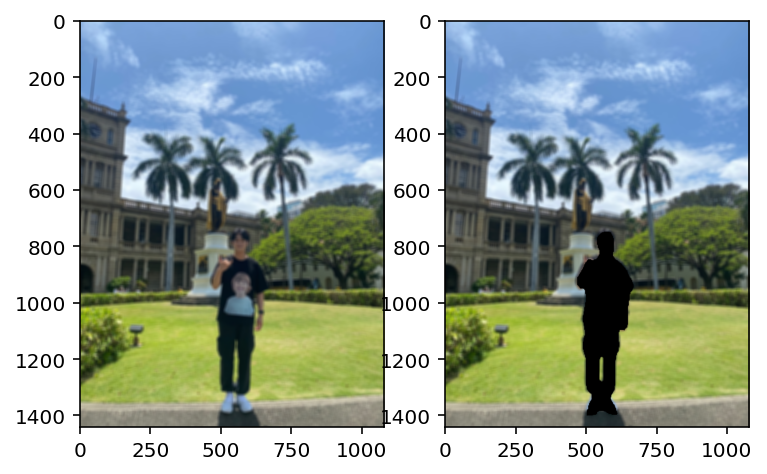

In [6]:
# (13,13)은 blurring kernel size를 뜻
# 값이 커질 수록 blurr의 강도가 심해진다.
img_orig_blur = cv2.blur(img_orig, (13,13))
plt.subplot(121)
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))

'''
bitwise_not 함수를 이용하면 이미지가 반전됩니다. 원래 마스크에서는 배경이 0, 
사람이 255였으니 bitwise_not 연산 이후 배경은 255, 사람은 0

반전된 세그멘테이션 결과를 이용해서 이미지와 bitwise_and 연산을 수행하면 
배경만 있는 영상을 얻음.

0과 어떤 수를 bitwise_and 연산을 해도 0이 되기 때문에 
사람이 0인 경우에는 사람이 있던 모든 픽셀이 0
'''

img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.subplot(122)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

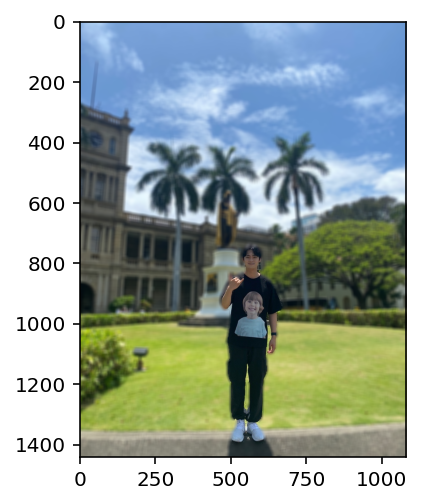

In [7]:
'''
blur image 완성
세그멘테이션 마스크가 255인 부분만 원본 이미지 값을 가지고 오고 아닌 영역은 블러된 이미지 값을 사용
'''

#np.where(조건,참,거짓)
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

## 04. Experiment

In [8]:
def blur_machine(file, obj, back = None):
    # data
    img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/' + file  
    img_orig = cv2.imread(img_path) 

    # model
    model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
    model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5')
    model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5'
    urllib.request.urlretrieve(model_url, model_file)
    model = semantic_segmentation()
    model.load_pascalvoc_model(model_file)

    # 이미지 입력
    segvalues, output = model.segmentAsPascalvoc(img_path)


    LABEL_NAMES = [
        'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
        'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
        'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
    ]

    colormap = np.zeros((256, 3), dtype = int)
    ind = np.arange(256, dtype=int)

    for shift in reversed(range(8)):
        for channel in range(3):
            colormap[:, channel] |= ((ind >> channel) & 1) << shift
        ind >>= 3

    seg_color = tuple(colormap[LABEL_NAMES.index(obj)][::-1])

    # output의 픽셀 별로 색상이 seg_color와 같다면 1(True), 다르다면 0(False)이 됩니다
    seg_map = np.all(output==seg_color, axis=-1)
    # True과 False인 값을 각각 255과 0으로 바꿔줍니다
    img_mask = seg_map.astype(np.uint8) * 255

    # 값이 커질 수록 blurr의 강도가 심해진다.
    
    plt.subplot(121)
    plt.title('Befor Blur')
    plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
    
    img_orig_blur = cv2.blur(img_orig, (13,13))
    plt.subplot(122)
    plt.title('After Blur')
    plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
    plt.show()
    
    img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
    img_bg_mask = cv2.bitwise_not(img_mask_color)
    img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
    plt.subplot(121)
    plt.title('Extract')
    plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))

    img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
    plt.subplot(122)
    plt.title('Compose')
    plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
    plt.show()
    
    # back이 있으면 
    if back:
        img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/' + back
        img_back = cv2.imread(img_path) 
        img_resized = cv2.resize(img_orig, (img_back.shape[1], img_back.shape[0]))
        img_mask_resized = cv2.resize(img_mask_color, (img_back.shape[1], img_back.shape[0]))
        img_background_concat = np.where(img_mask_resized == 255, img_resized, img_back)
        plt.subplot(121)
        plt.title('Background')
        plt.imshow(cv2.cvtColor(img_background_concat, cv2.COLOR_BGR2RGB))
        plt.show()
        

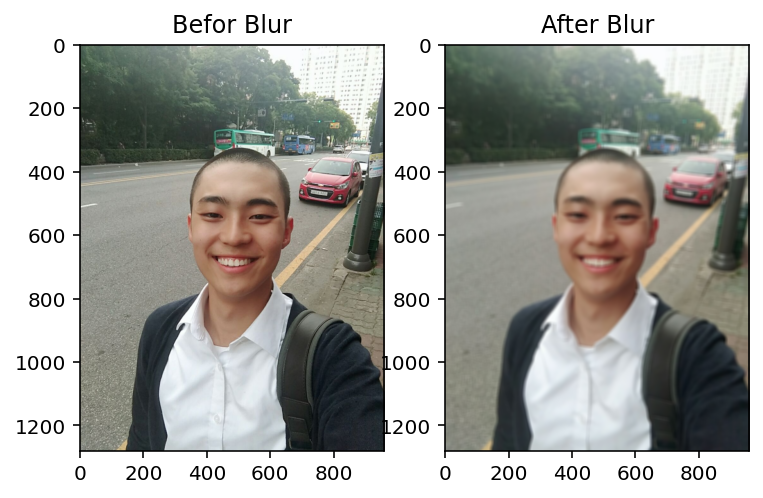

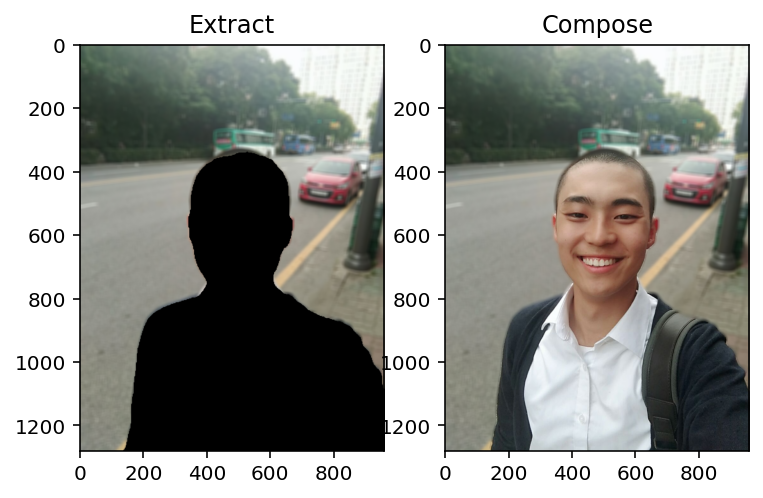

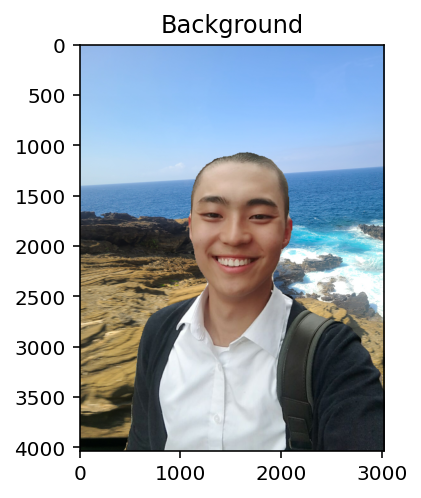

In [9]:
blur_machine('my_img.jpg', 'person','back.jpeg')

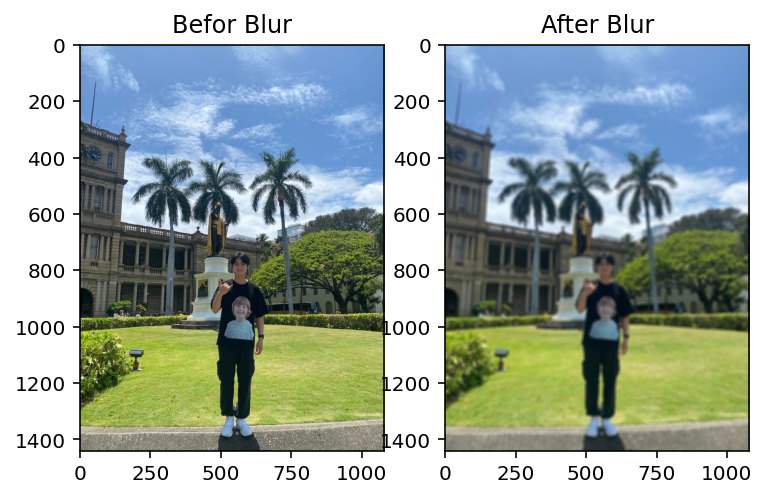

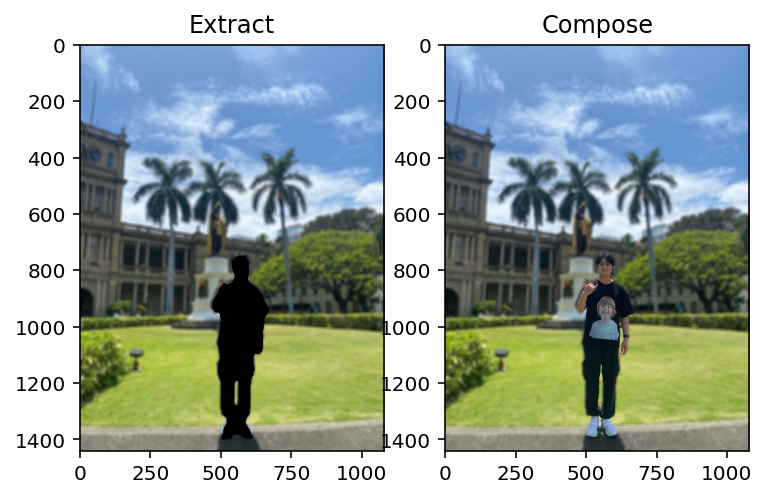

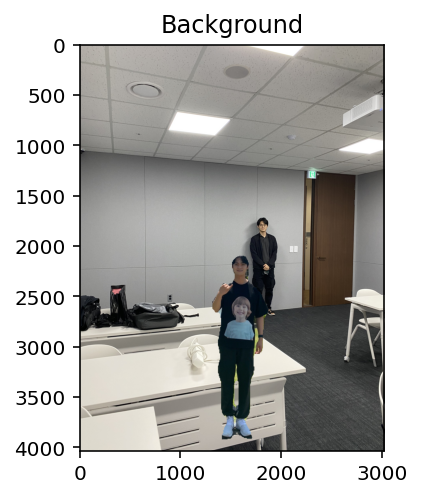

In [10]:
blur_machine('hawai.jpg', 'person','aiffel.jpeg')

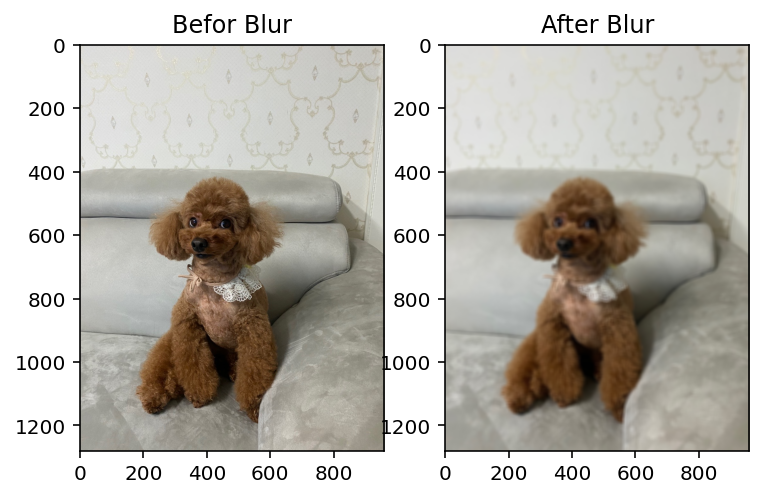

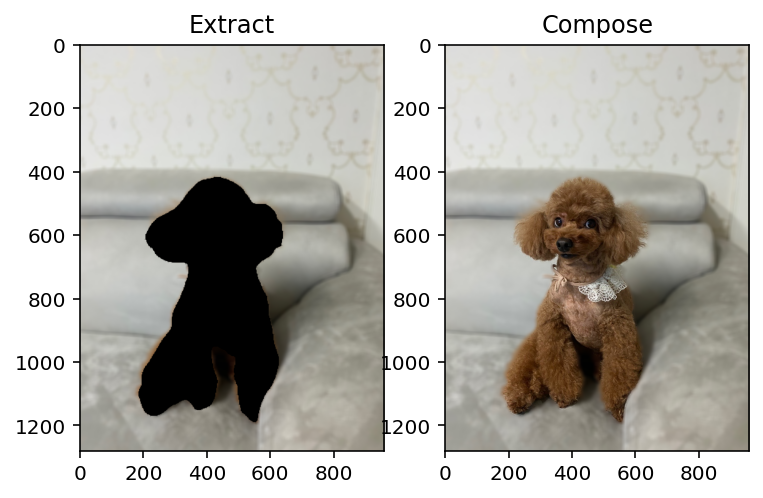

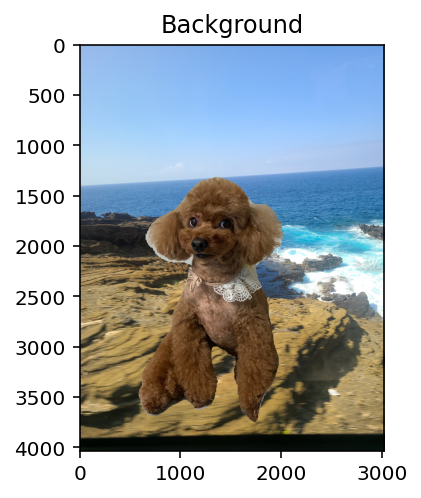

In [11]:
blur_machine('dog.jpg', 'dog','back.jpeg')

## 06. Problems

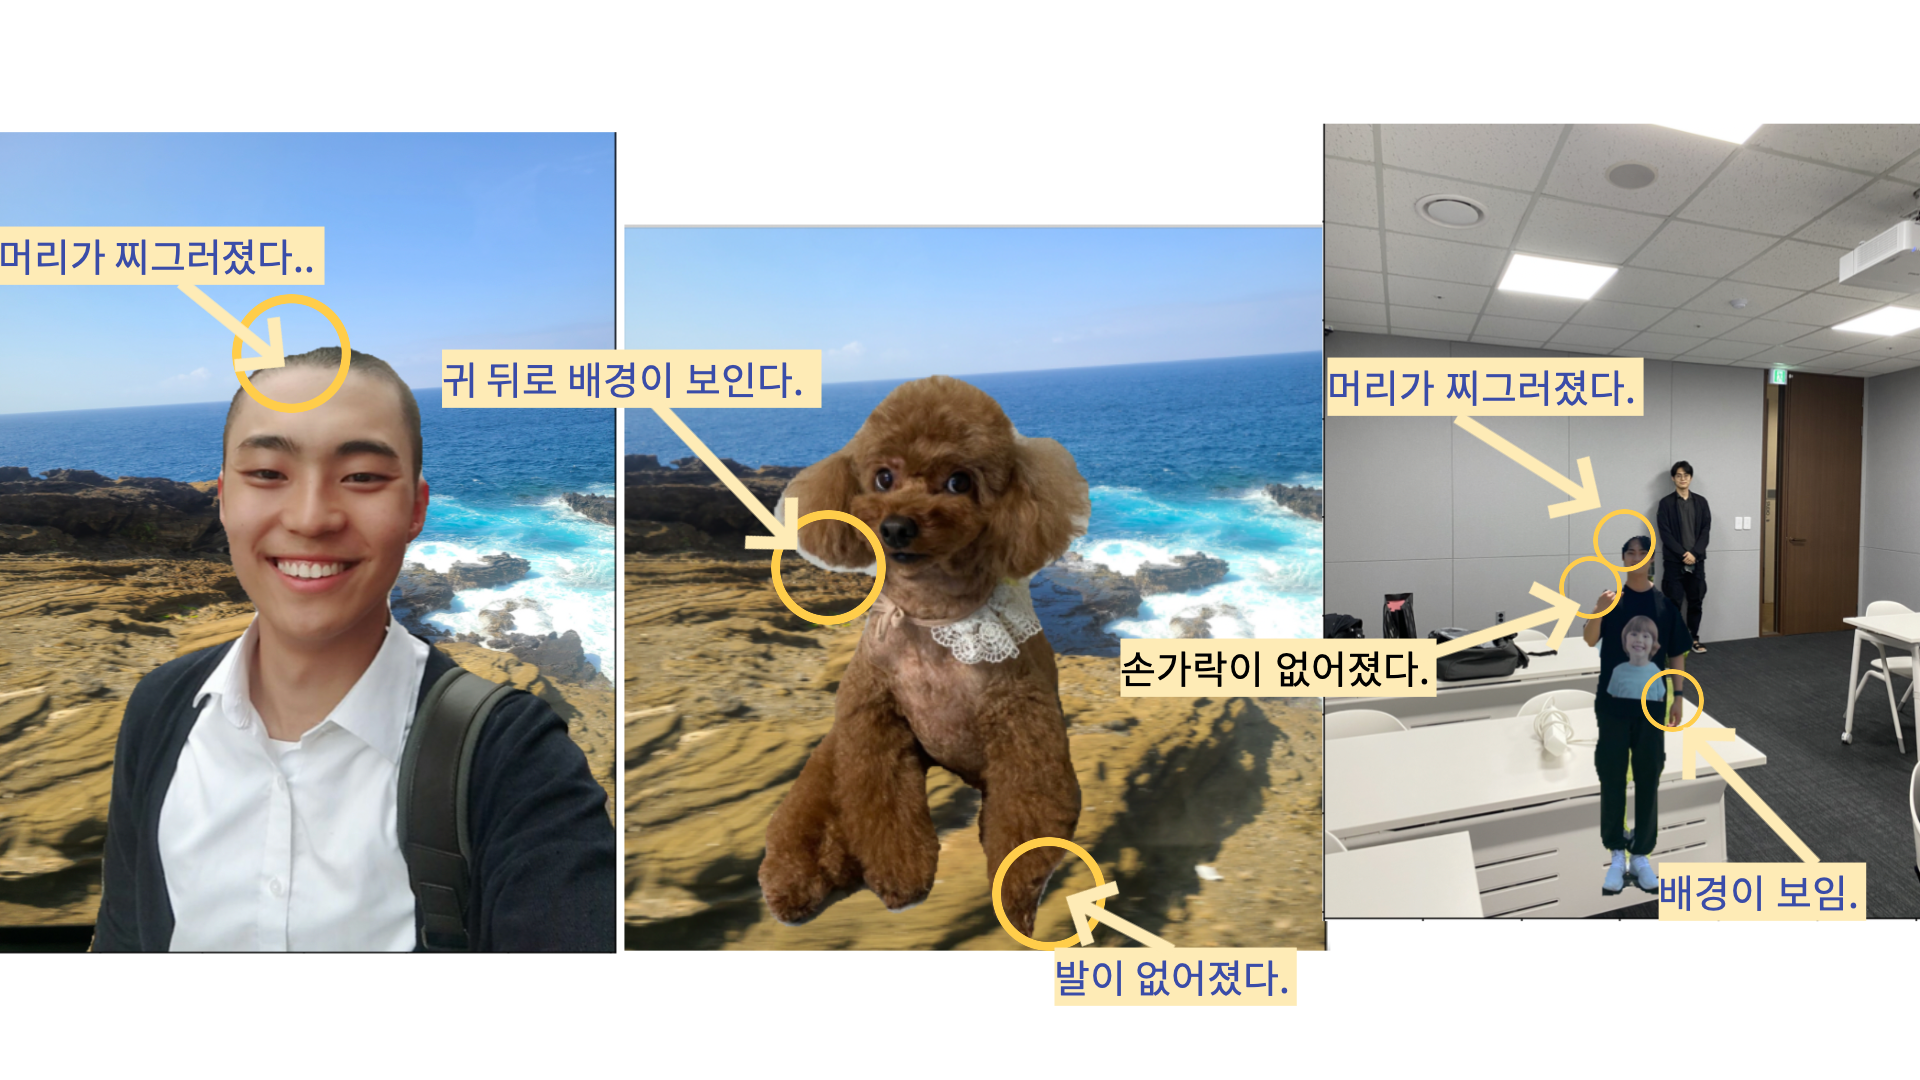

## 07. 회고

- **Problem**
    - 주로 경계선부분에서 문제점이 있었다.
    - 불분명한 경계선으로 인하여 인물을 더 자르게 되어서 훼손이 되었다.
    - 또한 크로마키 처리가 잘 되지 않아서 배경이 인물과 함께 포함되기도 하였다.
- **Solution**
    - 빛이나 비슷한 배경색이 있을때 주로 불분명한 경계선이 만들어진다.
    - 사진을 촬영할 때 순간의 사진을 찍는 것이 아니라 전후로 찰나의 시간 동안 몇장의 사진을 더 찍는다. 단 피사체의 움직임이 거의 없어야 한다.
    - 이후 각 사진에 semantic segmentation을 적용한 후 사진을 모두 합쳐 평균값을 내어 적용하여본다.
    - 다양한 mask들이 더 정확한 경계의 정보를 저장할 수 있을 것이라고 예상이 된다.
    - 앞에서 배웠던 앙상블과 같은 효과를 여기서 적용하면 어떨까 싶었다.
- **Resizing**
    - 크로마키와 배경을 합성할 때 사이즈를 같게 해주는 것이 중요했다. 많은 error가 있었는데 resizing으로 해결이 되었다.
